Find All Minima

---

Total frames: 322
Usable left heel frames: 322
Y-change threshold (filtering top 25%): 0.0630
Y-change range: 0.0051 to 0.0850
Kept minimum at frame 9: Y=0.828, change=0.0091
Filtered by Y-change: frame 37: Y=0.763, change=0.0720
Kept minimum at frame 60: Y=0.843, change=0.0189
Kept minimum at frame 71: Y=0.808, change=0.0599
Kept minimum at frame 87: Y=0.833, change=0.0051
Filtered by distance: frame 96
Filtered by Y-change: frame 112: Y=0.763, change=0.0821
Kept minimum at frame 134: Y=0.854, change=0.0289
Kept minimum at frame 153: Y=0.852, change=0.0088
Kept minimum at frame 164: Y=0.842, change=0.0197
Filtered by Y-change: frame 192: Y=0.772, change=0.0849
Kept minimum at frame 229: Y=0.867, change=0.0059
Kept minimum at frame 240: Y=0.868, change=0.0060
Filtered by Y-change: frame 266: Y=0.791, change=0.0850
Kept minimum at frame 288: Y=0.889, change=0.0258
Kept minimum at frame 314: Y=0.874, change=0.0077

Found 11 Local Minima:
Minimum 1: Frame 9, Time 0.300s, Y = 0.82781
Minim

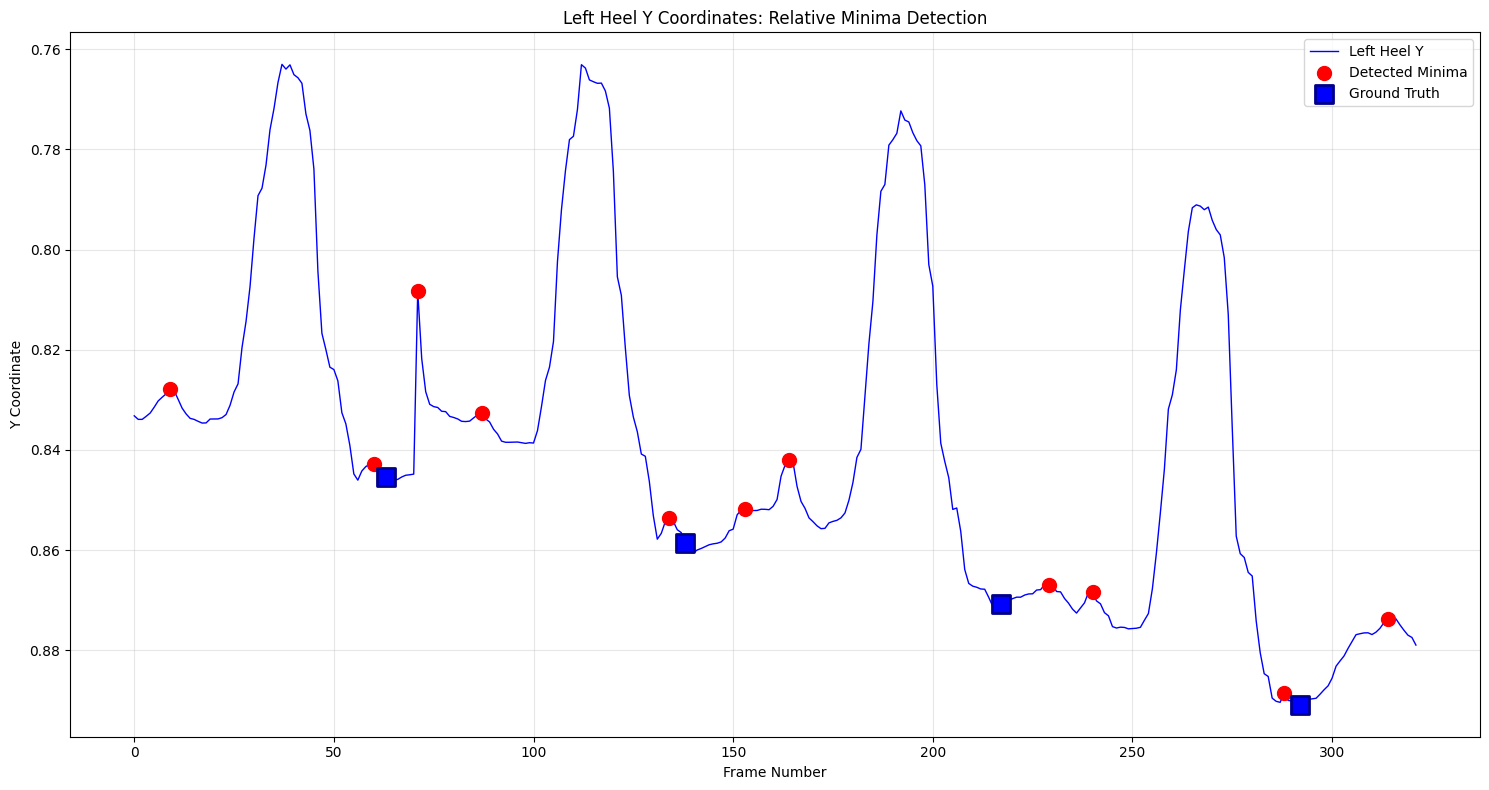

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where left heel is not usable (low confidence)
df_filtered = df[df['left_heel_usable'] == True].copy()

print(f"Total frames: {len(df)}")
print(f"Usable left heel frames: {len(df_filtered)}")

def find_local_minima_relative(df_data, window_size=3, min_distance=10, jump_threshold_percentile=75):
    """
    Find local minima while filtering out swing phase peaks based on relative Y changes
    
    Parameters:
    - jump_threshold_percentile: Ignore minima with Y changes above this percentile (filters swing phases)
    """
    minima = []
    y_values = df_data['left_heel_y'].values
    frames = df_data['frame_number'].values
    timestamps = df_data['timestamp'].values
    
    n = len(y_values)
    
    # First pass: find all potential minima and their Y-change magnitudes
    potential_minima = []
    
    for i in range(window_size, n - window_size):
        current_val = y_values[i]
        
        # Check if it's a local minimum
        is_minimum = True
        for j in range(i - window_size, i + window_size + 1):
            if j != i and y_values[j] <= current_val:
                is_minimum = False
                break
        
        if is_minimum:
            # Calculate the Y-change magnitude around this minimum
            # Look at larger window to see how much Y changed to reach this point
            look_back = min(15, i)  # Look back up to 15 frames
            look_forward = min(15, n - i - 1)  # Look forward up to 15 frames
            
            if look_back > 0 and look_forward > 0:
                before_y = np.mean(y_values[i-look_back:i])
                after_y = np.mean(y_values[i+1:i+look_forward+1])
                
                # Calculate how much Y dropped to reach this minimum
                drop_magnitude = abs(before_y - current_val)
                rise_magnitude = abs(after_y - current_val)
                total_change = drop_magnitude + rise_magnitude
                
                potential_minima.append({
                    'index': i,
                    'frame_number': frames[i],
                    'timestamp': timestamps[i],
                    'y_value': current_val,
                    'y_change_magnitude': total_change
                })
    
    if not potential_minima:
        return []
    
    # Calculate threshold for Y-change magnitude
    y_changes = [m['y_change_magnitude'] for m in potential_minima]
    change_threshold = np.percentile(y_changes, jump_threshold_percentile)
    
    print(f"Y-change threshold (filtering top {100-jump_threshold_percentile}%): {change_threshold:.4f}")
    print(f"Y-change range: {np.min(y_changes):.4f} to {np.max(y_changes):.4f}")
    
    # Second pass: filter out minima with large Y changes (swing phases)
    for minimum in potential_minima:
        if minimum['y_change_magnitude'] <= change_threshold:
            # Apply minimum distance constraint
            if not minima or (minimum['index'] - minima[-1]['index']) >= min_distance:
                minima.append({
                    'index': minimum['index'],
                    'frame_number': minimum['frame_number'],
                    'timestamp': minimum['timestamp'],
                    'y_value': minimum['y_value']
                })
                print(f"Kept minimum at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}, change={minimum['y_change_magnitude']:.4f}")
            else:
                print(f"Filtered by distance: frame {minimum['frame_number']}")
        else:
            print(f"Filtered by Y-change: frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}, change={minimum['y_change_magnitude']:.4f}")
    
    return minima

# Add this after your function definition:

# Find local minima using relative approach
minima = find_local_minima_relative(df_filtered, window_size=3, min_distance=10, jump_threshold_percentile=75)

print(f"\nFound {len(minima)} Local Minima:")
for i, minimum in enumerate(minima):
    print(f"Minimum {i+1}: Frame {minimum['frame_number']}, "
          f"Time {minimum['timestamp']:.3f}s, Y = {minimum['y_value']:.5f}")

# Extract ground truth left foot steps  
gt_left_steps = [step for step in gt_data['annotations'] if step['foot'] == 'left']
print(f"\nGround truth left foot steps: {len(gt_left_steps)}")

# Get Y coordinates for ground truth frames
gt_frames = []
gt_y_values = []
for gt_step in gt_left_steps:
    frame_num = gt_step['frame']
    matching_row = df_filtered[df_filtered['frame_number'] == frame_num]
    if not matching_row.empty:
        gt_frames.append(frame_num)
        gt_y_values.append(matching_row['left_heel_y'].iloc[0])

# Visualize results
plt.figure(figsize=(15, 8))
plt.plot(df_filtered['frame_number'], df_filtered['left_heel_y'], 'b-', linewidth=1, label='Left Heel Y')

# Mark detected minima (RED dots)
if minima:
    min_frames = [m['frame_number'] for m in minima]
    min_y_vals = [m['y_value'] for m in minima]
    plt.scatter(min_frames, min_y_vals, color='red', s=100, zorder=5, label='Detected Minima')

# Mark ground truth (BLUE dots)
if gt_frames:
    plt.scatter(gt_frames, gt_y_values, color='blue', s=150, marker='s', zorder=6, 
               label='Ground Truth', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate')
plt.title('Left Heel Y Coordinates: Relative Minima Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

------

**Completed Code for left foot**!!!

---

Total frames: 322
Usable left heel frames: 322
Y-change threshold (filtering top 25%): 0.0630
Filtered - no preceding swing phase found: frame 9
Swing phase peak detected at frame 37: Y=0.763
Kept first minimum after swing at frame 60: Y=0.843
Filtered - no preceding swing phase found: frame 71
Filtered - already detected after this swing cycle: frame 87
Filtered - already detected after this swing cycle: frame 96
Swing phase peak detected at frame 112: Y=0.763
Kept first minimum after swing at frame 134: Y=0.854
Filtered - already detected after this swing cycle: frame 153
Filtered - already detected after this swing cycle: frame 164
Swing phase peak detected at frame 192: Y=0.772
Kept first minimum after swing at frame 229: Y=0.867
Filtered - already detected after this swing cycle: frame 240
Swing phase peak detected at frame 266: Y=0.791
Kept first minimum after swing at frame 288: Y=0.889
Filtered - already detected after this swing cycle: frame 314

Found 4 Local Minima:
Minimum 

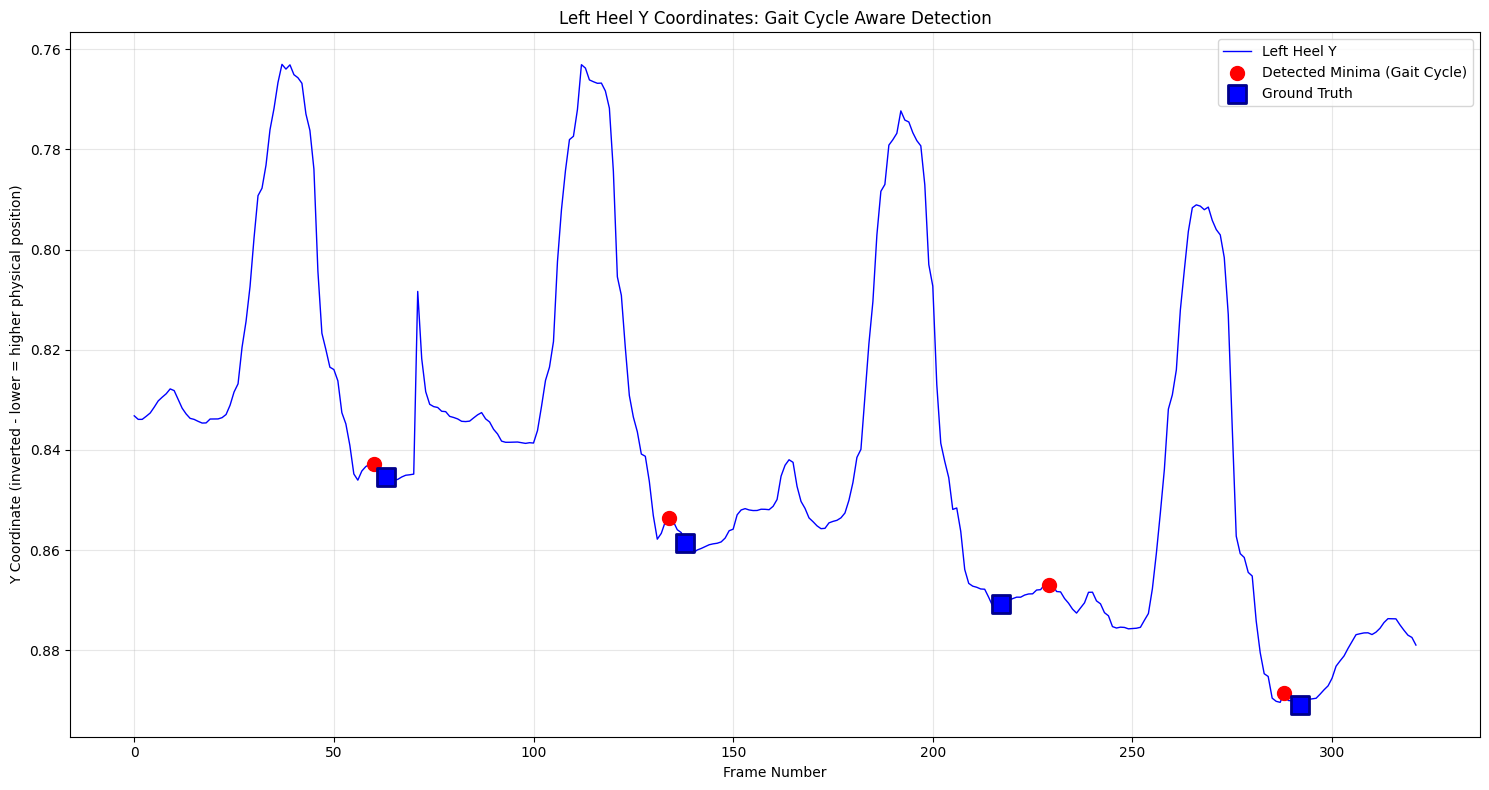


COMPARISON:
Ground truth left steps: 4
Detected minima: 4
Detection ratio: 1.00


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where left heel is not usable (low confidence)
df_filtered = df[df['left_heel_usable'] == True].copy()

print(f"Total frames: {len(df)}")
print(f"Usable left heel frames: {len(df_filtered)}")

def find_local_minima_with_gait_cycle(df_data, window_size=3, min_distance=10, jump_threshold_percentile=75):
    """
    Find local minima with gait cycle awareness - only detect first minimum after swing phase
    """
    minima = []
    y_values = df_data['left_heel_y'].values
    frames = df_data['frame_number'].values
    timestamps = df_data['timestamp'].values
    
    n = len(y_values)
    
    # First pass: find all potential minima and their Y-change magnitudes
    potential_minima = []
    
    for i in range(window_size, n - window_size):
        current_val = y_values[i]
        
        # Check if it's a local minimum
        is_minimum = True
        for j in range(i - window_size, i + window_size + 1):
            if j != i and y_values[j] <= current_val:
                is_minimum = False
                break
        
        if is_minimum:
            # Calculate the Y-change magnitude around this minimum
            look_back = min(15, i)
            look_forward = min(15, n - i - 1)
            
            if look_back > 0 and look_forward > 0:
                before_y = np.mean(y_values[i-look_back:i])
                after_y = np.mean(y_values[i+1:i+look_forward+1])
                
                drop_magnitude = abs(before_y - current_val)
                rise_magnitude = abs(after_y - current_val)
                total_change = drop_magnitude + rise_magnitude
                
                potential_minima.append({
                    'index': i,
                    'frame_number': frames[i],
                    'timestamp': timestamps[i],
                    'y_value': current_val,
                    'y_change_magnitude': total_change
                })
    
    if not potential_minima:
        return []
    
    # Calculate threshold for Y-change magnitude
    y_changes = [m['y_change_magnitude'] for m in potential_minima]
    change_threshold = np.percentile(y_changes, jump_threshold_percentile)
    
    print(f"Y-change threshold (filtering top {100-jump_threshold_percentile}%): {change_threshold:.4f}")
    
    # Second pass: apply gait cycle logic
    last_swing_peak_frame = -1
    
    for minimum in potential_minima:
        if minimum['y_change_magnitude'] <= change_threshold:
            current_y = minimum['y_value']
            current_frame = minimum['frame_number']
            
            # Detect if we're transitioning from swing to stance
            swing_peaks_nearby = [m for m in potential_minima 
                                if m['y_change_magnitude'] > change_threshold 
                                and m['frame_number'] < current_frame 
                                and current_frame - m['frame_number'] < 60  # Within last 30 frames
                                and m['y_value'] < current_y - 0.05]  # Significantly lower Y
            
            if swing_peaks_nearby:
                # We found a swing peak before this minimum
                latest_swing = max(swing_peaks_nearby, key=lambda x: x['frame_number'])
                
                # Only detect if this is the first minimum after a swing peak
                if latest_swing['frame_number'] > last_swing_peak_frame:
                    # This is the first detection after a new swing phase
                    if not minima or (minimum['index'] - minima[-1]['index']) >= min_distance:
                        minima.append({
                            'index': minimum['index'],
                            'frame_number': minimum['frame_number'],
                            'timestamp': minimum['timestamp'],
                            'y_value': minimum['y_value']
                        })
                        last_swing_peak_frame = latest_swing['frame_number']
                        print(f"Kept first minimum after swing at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
                    else:
                        print(f"Filtered by distance: frame {minimum['frame_number']}")
                else:
                    print(f"Filtered - already detected after this swing cycle: frame {minimum['frame_number']}")
            else:
                print(f"Filtered - no preceding swing phase found: frame {minimum['frame_number']}")
        else:
            print(f"Swing phase peak detected at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
    
    return minima

# Find local minima using gait cycle approach
minima = find_local_minima_with_gait_cycle(df_filtered, window_size=3, min_distance=10, jump_threshold_percentile=75)

print(f"\nFound {len(minima)} Local Minima:")
for i, minimum in enumerate(minima):
    print(f"Minimum {i+1}: Frame {minimum['frame_number']}, "
          f"Time {minimum['timestamp']:.3f}s, Y = {minimum['y_value']:.5f}")

# Extract ground truth left foot steps  
gt_left_steps = [step for step in gt_data['annotations'] if step['foot'] == 'left']
print(f"\nGround truth left foot steps: {len(gt_left_steps)}")

# Get Y coordinates for ground truth frames
gt_frames = []
gt_y_values = []
for gt_step in gt_left_steps:
    frame_num = gt_step['frame']
    matching_row = df_filtered[df_filtered['frame_number'] == frame_num]
    if not matching_row.empty:
        gt_frames.append(frame_num)
        gt_y_values.append(matching_row['left_heel_y'].iloc[0])
        print(f"GT: Frame {frame_num}, Time {gt_step['timestamp']:.3f}s, Y = {matching_row['left_heel_y'].iloc[0]:.5f}")

# Calculate intervals between steps
if len(minima) > 1:
    intervals = []
    for i in range(1, len(minima)):
        interval = minima[i]['timestamp'] - minima[i-1]['timestamp']
        intervals.append(interval)
    
    print(f"\nDetected step intervals:")
    for i, interval in enumerate(intervals):
        print(f"  Interval {i+1}: {interval:.3f}s")
    
    print(f"\nTiming statistics:")
    print(f"  Average interval: {np.mean(intervals):.3f}s")
    print(f"  Std deviation: {np.std(intervals):.3f}s")

# Visualize results
plt.figure(figsize=(15, 8))
plt.plot(df_filtered['frame_number'], df_filtered['left_heel_y'], 'b-', linewidth=1, label='Left Heel Y')

# Mark detected minima (RED dots)
if minima:
    min_frames = [m['frame_number'] for m in minima]
    min_y_vals = [m['y_value'] for m in minima]
    plt.scatter(min_frames, min_y_vals, color='red', s=100, zorder=5, label='Detected Minima (Gait Cycle)')

# Mark ground truth (BLUE squares)
if gt_frames:
    plt.scatter(gt_frames, gt_y_values, color='blue', s=150, marker='s', zorder=6, 
               label='Ground Truth', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate (inverted - lower = higher physical position)')
plt.title('Left Heel Y Coordinates: Gait Cycle Aware Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('left_heel_gait_cycle_detection.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare detection accuracy
print(f"\n{'='*50}")
print("COMPARISON:")
print(f"Ground truth left steps: {len(gt_left_steps)}")
print(f"Detected minima: {len(minima)}")
print(f"Detection ratio: {len(minima)/len(gt_left_steps):.2f}" if gt_left_steps else "N/A")

---

Both feet

---

Total frames: 322
Usable heel frames: 322

--- Processing LEFT foot ---
LEFT Y-change threshold: 0.0630
Filtered - no preceding swing phase found: frame 9
Swing phase peak detected at frame 37: Y=0.763
Kept left minimum at frame 60: Y=0.843
Filtered - no preceding swing phase found: frame 71
Filtered - already detected after this swing cycle: frame 87
Filtered - already detected after this swing cycle: frame 96
Swing phase peak detected at frame 112: Y=0.763
Kept left minimum at frame 134: Y=0.854
Filtered - already detected after this swing cycle: frame 153
Filtered - already detected after this swing cycle: frame 164
Swing phase peak detected at frame 192: Y=0.772
Kept left minimum at frame 229: Y=0.867
Filtered - already detected after this swing cycle: frame 240
Swing phase peak detected at frame 266: Y=0.791
Kept left minimum at frame 288: Y=0.889
Filtered - already detected after this swing cycle: frame 314

--- Processing RIGHT foot ---
RIGHT Y-change threshold: 0.1022
Filtered 

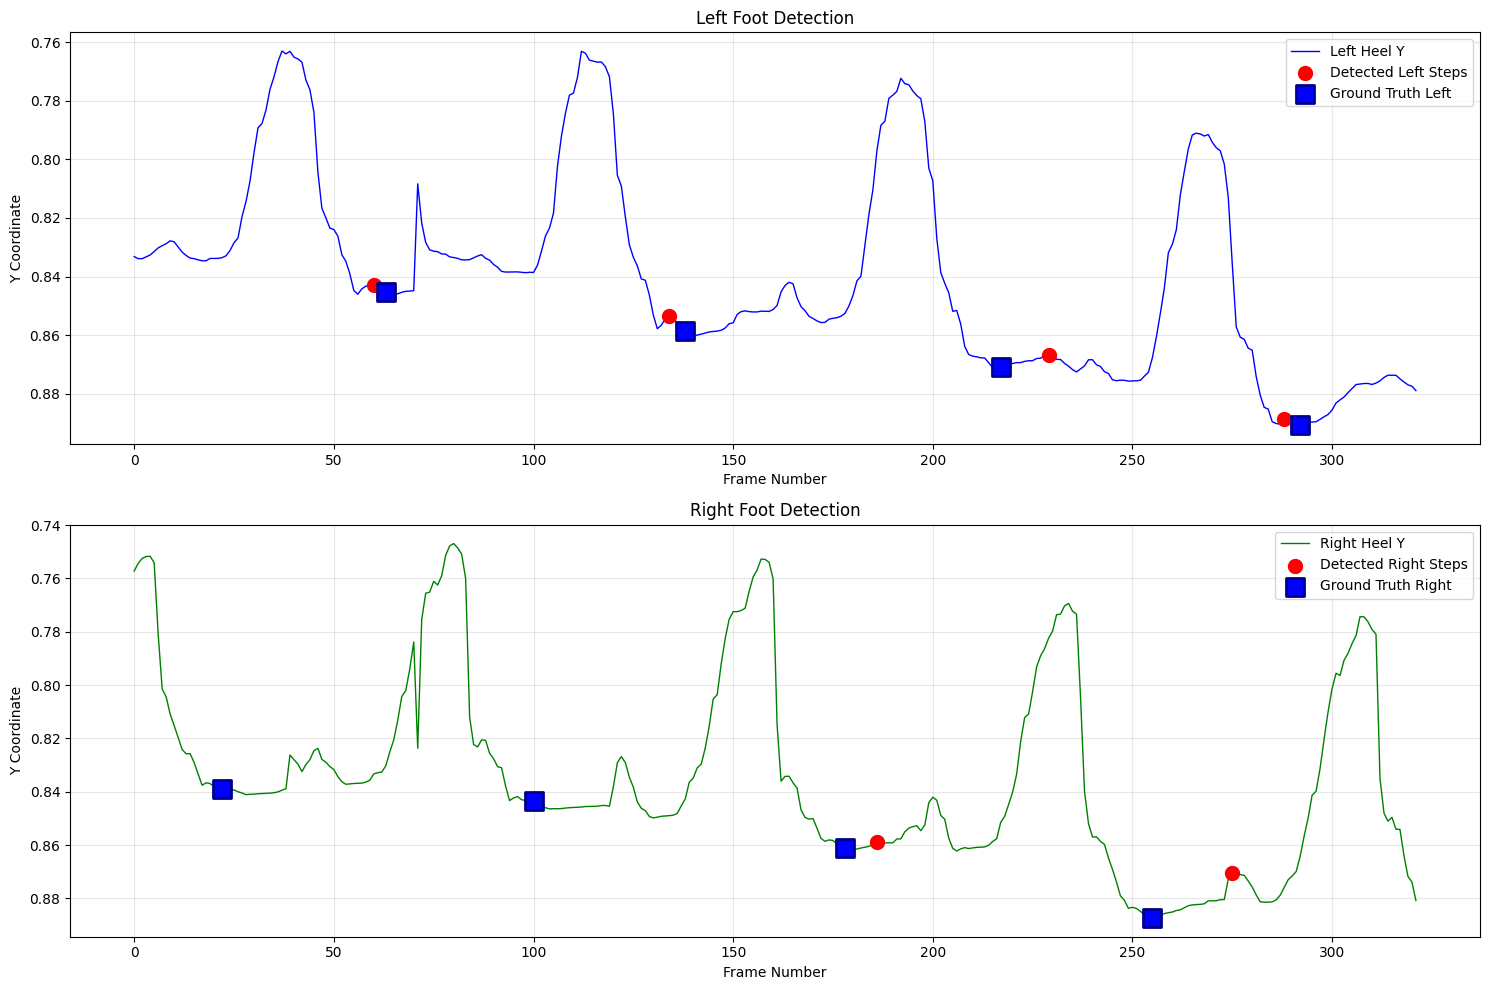


COMPARISON:
Ground truth total steps: 8
Detected total steps: 6
Ground truth - Left: 4, Right: 4
Detected - Left: 4, Right: 2


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where heels are usable (low confidence)
df_filtered = df[(df['left_heel_usable'] == True) | (df['right_heel_usable'] == True)].copy()

print(f"Total frames: {len(df)}")
print(f"Usable heel frames: {len(df_filtered)}")

def find_local_minima_both_feet(df_data, window_size=3, min_distance=10, jump_threshold_percentile=75):
    """
    Find local minima for both left and right feet
    """
    all_minima = []
    
    for foot in ['left', 'right']:
        print(f"\n--- Processing {foot.upper()} foot ---")
        
        # Filter for frames where this foot is usable
        foot_data = df_data[df_data[f'{foot}_heel_usable'] == True].copy()
        
        if len(foot_data) == 0:
            print(f"No usable {foot} heel data")
            continue
            
        minima = []
        y_values = foot_data[f'{foot}_heel_y'].values
        frames = foot_data['frame_number'].values
        timestamps = foot_data['timestamp'].values
        
        n = len(y_values)
        
        # First pass: find all potential minima and their Y-change magnitudes
        potential_minima = []
        
        for i in range(window_size, n - window_size):
            current_val = y_values[i]
            
            # Check if it's a local minimum
            is_minimum = True
            for j in range(i - window_size, i + window_size + 1):
                if j != i and y_values[j] <= current_val:
                    is_minimum = False
                    break
            
            if is_minimum:
                # Calculate the Y-change magnitude around this minimum
                look_back = min(15, i)
                look_forward = min(15, n - i - 1)
                
                if look_back > 0 and look_forward > 0:
                    before_y = np.mean(y_values[i-look_back:i])
                    after_y = np.mean(y_values[i+1:i+look_forward+1])
                    
                    drop_magnitude = abs(before_y - current_val)
                    rise_magnitude = abs(after_y - current_val)
                    total_change = drop_magnitude + rise_magnitude
                    
                    potential_minima.append({
                        'index': i,
                        'frame_number': frames[i],
                        'timestamp': timestamps[i],
                        'y_value': current_val,
                        'y_change_magnitude': total_change,
                        'foot': foot
                    })
        
        if not potential_minima:
            print(f"No potential minima found for {foot} foot")
            continue
        
        # Calculate threshold for Y-change magnitude
        y_changes = [m['y_change_magnitude'] for m in potential_minima]
        change_threshold = np.percentile(y_changes, jump_threshold_percentile)
        
        print(f"{foot.upper()} Y-change threshold: {change_threshold:.4f}")
        
        # Second pass: apply gait cycle logic
        last_swing_peak_frame = -1
        
        for minimum in potential_minima:
            if minimum['y_change_magnitude'] <= change_threshold:
                current_y = minimum['y_value']
                current_frame = minimum['frame_number']
                
                # Detect if we're transitioning from swing to stance
                swing_peaks_nearby = [m for m in potential_minima 
                                    if m['y_change_magnitude'] > change_threshold 
                                    and m['frame_number'] < current_frame 
                                    and current_frame - m['frame_number'] < 60
                                    and m['y_value'] < current_y - 0.05]
                
                if swing_peaks_nearby:
                    # We found a swing peak before this minimum
                    latest_swing = max(swing_peaks_nearby, key=lambda x: x['frame_number'])
                    
                    # Only detect if this is the first minimum after a swing peak
                    if latest_swing['frame_number'] > last_swing_peak_frame:
                        # This is the first detection after a new swing phase
                        if not minima or (minimum['index'] - minima[-1]['index']) >= min_distance:
                            minima.append({
                                'index': minimum['index'],
                                'frame_number': minimum['frame_number'],
                                'timestamp': minimum['timestamp'],
                                'y_value': minimum['y_value'],
                                'foot': foot
                            })
                            last_swing_peak_frame = latest_swing['frame_number']
                            print(f"Kept {foot} minimum at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
                        else:
                            print(f"Filtered by distance: frame {minimum['frame_number']}")
                    else:
                        print(f"Filtered - already detected after this swing cycle: frame {minimum['frame_number']}")
                else:
                    print(f"Filtered - no preceding swing phase found: frame {minimum['frame_number']}")
            else:
                print(f"Swing phase peak detected at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
        
        all_minima.extend(minima)
    
    # Sort all detections by frame number
    all_minima.sort(key=lambda x: x['frame_number'])
    return all_minima

# Find local minima for both feet
all_detections = find_local_minima_both_feet(df_filtered, window_size=3, min_distance=10, jump_threshold_percentile=75)

print(f"\nFound {len(all_detections)} Total Detections:")
for i, detection in enumerate(all_detections):
    print(f"Detection {i+1}: Frame {detection['frame_number']}, "
          f"Time {detection['timestamp']:.3f}s, {detection['foot'].upper()} foot, Y = {detection['y_value']:.5f}")

# Separate left and right detections
left_detections = [d for d in all_detections if d['foot'] == 'left']
right_detections = [d for d in all_detections if d['foot'] == 'right']

print(f"\nLeft foot detections: {len(left_detections)}")
print(f"Right foot detections: {len(right_detections)}")

# Extract ground truth for both feet
gt_left_steps = [step for step in gt_data['annotations'] if step['foot'] == 'left']
gt_right_steps = [step for step in gt_data['annotations'] if step['foot'] == 'right']

print(f"\nGround truth - Left: {len(gt_left_steps)}, Right: {len(gt_right_steps)}")

# Visualize results
plt.figure(figsize=(15, 10))

# Plot left foot
plt.subplot(2, 1, 1)
df_left_usable = df_filtered[df_filtered['left_heel_usable'] == True]
plt.plot(df_left_usable['frame_number'], df_left_usable['left_heel_y'], 'b-', linewidth=1, label='Left Heel Y')

# Mark detected left minima
if left_detections:
    left_frames = [d['frame_number'] for d in left_detections]
    left_y_vals = [d['y_value'] for d in left_detections]
    plt.scatter(left_frames, left_y_vals, color='red', s=100, zorder=5, label='Detected Left Steps')

# Mark ground truth left steps
gt_left_frames = [step['frame'] for step in gt_left_steps]
gt_left_y = []
for frame in gt_left_frames:
    matching_row = df_left_usable[df_left_usable['frame_number'] == frame]
    if not matching_row.empty:
        gt_left_y.append(matching_row['left_heel_y'].iloc[0])

if gt_left_frames and gt_left_y:
    plt.scatter(gt_left_frames[:len(gt_left_y)], gt_left_y, color='blue', s=150, marker='s', 
               zorder=6, label='Ground Truth Left', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate')
plt.title('Left Foot Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()

# Plot right foot
plt.subplot(2, 1, 2)
df_right_usable = df_filtered[df_filtered['right_heel_usable'] == True]
plt.plot(df_right_usable['frame_number'], df_right_usable['right_heel_y'], 'g-', linewidth=1, label='Right Heel Y')

# Mark detected right minima
if right_detections:
    right_frames = [d['frame_number'] for d in right_detections]
    right_y_vals = [d['y_value'] for d in right_detections]
    plt.scatter(right_frames, right_y_vals, color='red', s=100, zorder=5, label='Detected Right Steps')

# Mark ground truth right steps
gt_right_frames = [step['frame'] for step in gt_right_steps]
gt_right_y = []
for frame in gt_right_frames:
    matching_row = df_right_usable[df_right_usable['frame_number'] == frame]
    if not matching_row.empty:
        gt_right_y.append(matching_row['right_heel_y'].iloc[0])

if gt_right_frames and gt_right_y:
    plt.scatter(gt_right_frames[:len(gt_right_y)], gt_right_y, color='blue', s=150, marker='s', 
               zorder=6, label='Ground Truth Right', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate')
plt.title('Right Foot Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('both_feet_detection.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare detection accuracy
print(f"\n{'='*60}")
print("COMPARISON:")
print(f"Ground truth total steps: {len(gt_data['annotations'])}")
print(f"Detected total steps: {len(all_detections)}")
print(f"Ground truth - Left: {len(gt_left_steps)}, Right: {len(gt_right_steps)}")
print(f"Detected - Left: {len(left_detections)}, Right: {len(right_detections)}")